### Pull Weather Data from API 
#### Raleigh, Charlotte, DC 1946 - 2015

In [1]:
%%capture
import numpy as np
import json
import requests
import pandas as pd
from swat import *
import swat.cas.datamsghandlers as dmh
from matplotlib import pyplot as plt
%matplotlib inline

#Connect to CAS Server
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

#Load Actionsets
sess.loadactionset(actionset = "sampling")
sess.loadactionset(actionset="datastep")
sess.loadactionset(actionset = "regression")
sess.loadactionset(actionset = "decisionTree")
sess.loadactionset(actionset = "neuralNet")
sess.loadactionset(actionset = "svm")
sess.loadactionset(actionset = "astore")

#Sites we will loop through
site_name=['RDU','Reagan_Intl', 'CLT']
site_id=['GHCND:USW00013722','GHCND:USW00013743', 'GHCND:USW00013881']

### Pull data for a specific location for 10 year interval (max allowed by API in one call)

In [2]:
def return_results(url):
    
    #Create dictionaries for variable
    columns=['Year','SNOW','TAVG','CLDD','DX32','TMIN','TMAX',
             'HTDD','DX90','DP01', 'DP05','DT32','FZF0','PRCP']
    all_col={}
    for column in columns:
        all_col[column] = []
   
    #Call API
    headers = {'token': 'HGQwYMutaGbKyJUqOZchjtieVMKpMMTE'}
    response = requests.get(url, headers=headers)
    parsed=json.loads(response.text)   
       
    for record in parsed['results']:
        for i in range(1,len(columns)):
            if record['datatype'] == columns[i]: 
                if i==1:
                    all_col['Year'].append(record['date'])
                all_col[columns[i]].append(record['value'])
               
    return all_col

### Pull data in 10 year intervals for a specific site and merge results

In [3]:
def year_loop(start,end, by, code):
    
    columns=['Year','SNOW','TAVG','CLDD','DX32','TMIN','TMAX',
             'HTDD','DX90','DP01', 'DP05','DT32','FZF0','PRCP']
    all_col2={}
    for column in columns:
        all_col2[column] = []
        
    url='http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GSOY&stationid=id_code&startdate=1946-01-01&enddate=1955-01-01&limit=1000'
    url=url.replace('id_code', code)

    ranges=np.arange(start, end+1, by)
    
    for i in range(len(ranges)-1):
        
        all_cols = return_results(url)

        for key, value in all_cols.items():
            all_col2[key].extend(value)
        
        if i==6:
            pass

        else:
            url=url.replace(str(ranges[i+1]-1),str(ranges[i+2]-1))
            url=url.replace(str(ranges[i]),str(ranges[i+1]))
        
    all_col2=pd.DataFrame.from_dict(all_col2)
    all_col2['Year']=all_col2['Year'].map(lambda x: x[:4])

    return all_col2

### Pull data for Raleigh, Charlotte and DC from 1946 - 2010  

In [4]:
API_Data=pd.DataFrame()
for i in range(len(site_name)):
    temp=year_loop(1946,2016,10,site_id[i])
    temp['Location']=site_name[i]
    API_Data=pd.concat([API_Data, temp], axis=0)

In [5]:
API_Data.head()

,CLDD,DP01,DP05,DT32,DX32,DX90,FZF0,HTDD,PRCP,SNOW,TAVG,TMAX,TMIN,Year,Location
0,721.9,131,35,50,0,28,0.0,1834.8,1280.4,138,15.82,21.95,9.68,1946,RDU
1,855.3,133,28,92,3,44,0.0,1905.6,1168.2,99,14.83,20.89,8.77,1947,RDU
2,856.4,149,39,61,8,49,0.0,1978.7,1327.1,622,15.48,21.72,9.23,1948,RDU
3,903.8,126,27,58,0,44,-1.1,1611.2,1106.1,0,16.33,22.36,10.29,1949,RDU
4,840.5,125,22,77,1,44,0.0,1709.7,962.2,8,15.47,21.78,9.16,1950,RDU


### Load to CAS (If table does not already exist on server)

In [6]:
if not sess.table.tableExists(table='NCDC_Weather_Data').exists:
    sess.addtable(table='NCDC_Weather_Data', **dmh.PandasDataFrame(API_Data).args.addtable, replace=True)

### See the data on VIYA server

In [7]:
sess.CASTable('NCDC_Weather_Data').head()

,CLDD,DP01,DP05,DT32,DX32,DX90,FZF0,HTDD,PRCP,SNOW,TAVG,TMAX,TMIN,Year,Location
0,721.9,131,35,50,0,28,0.0,1834.8,1280.4,138,15.82,21.95,9.68,1946,RDU
1,855.3,133,28,92,3,44,0.0,1905.6,1168.2,99,14.83,20.89,8.77,1947,RDU
2,856.4,149,39,61,8,49,0.0,1978.7,1327.1,622,15.48,21.72,9.23,1948,RDU
3,903.8,126,27,58,0,44,-1.1,1611.2,1106.1,0,16.33,22.36,10.29,1949,RDU
4,840.5,125,22,77,1,44,0.0,1709.7,962.2,8,15.47,21.78,9.16,1950,RDU


### Load Variable Shortcuts and Data Dictionary

In [8]:
#Variable Shortcuts
target='SNOW_FLAG'
class_inputs=['Location']
interval_inputs=['TAVG', 'CLDD', 'DX32', 'TMIN', 'TMAX', 'HTDD', 'DX90', 'DP01', 'DP05', 'DT32', 'FZF0', 'PRCP']
all_inputs = interval_inputs + class_inputs

class_vars = [target] + class_inputs 
all_vars= class_vars + ['Year'] + interval_inputs

labels=['<100mm of Snow in Year', 'Location of weather station','Calendar Year','AVG Temp C', 'Cooling Degree Days',
        '# Days max temp <32 F', 'Min Temp', 'Max Temp','Heating Degree Days','# Days max>90F','# Day > .1 inch Precip',
        '# Day > .5 inch of precip','# Day min tem < 32F','Temp first freeze < 32F', 'Precpitation for year']

#Data Dictionary for difficult variables
Data_Dictionary=pd.DataFrame({
   'Variable': all_vars,
   'Definition': labels
        })

Data_Dictionary

,Definition,Variable
0,<100mm of Snow in Year,SNOW_FLAG
1,Location of weather station,Location
2,Calendar Year,Year
3,AVG Temp C,TAVG
4,Cooling Degree Days,CLDD
5,# Days max temp <32 F,DX32
6,Min Temp,TMIN
7,Max Temp,TMAX
8,Heating Degree Days,HTDD
9,# Days max>90F,DX90


### Add a Target variable with Database Step (Done in CAS, not locally)
#### where Snow amount < 100 MM for the year

In [9]:
sess.dataStep.runCode(
  code="data NCDC_Weather_Data; set NCDC_Weather_Data; if SNOW < 100 then SNOW_FLAG=1; else SNOW_FLAG=0; run;"
)

sess.CASTable('NCDC_Weather_Data').head()

,CLDD,DP01,DP05,DT32,DX32,DX90,FZF0,HTDD,PRCP,SNOW,TAVG,TMAX,TMIN,Year,Location,SNOW_FLAG
0,721.9,131.0,35.0,50.0,0.0,28.0,0.0,1834.8,1280.4,138.0,15.82,21.95,9.68,1946,RDU,0.0
1,855.3,133.0,28.0,92.0,3.0,44.0,0.0,1905.6,1168.2,99.0,14.83,20.89,8.77,1947,RDU,1.0
2,856.4,149.0,39.0,61.0,8.0,49.0,0.0,1978.7,1327.1,622.0,15.48,21.72,9.23,1948,RDU,0.0
3,903.8,126.0,27.0,58.0,0.0,44.0,-1.1,1611.2,1106.1,0.0,16.33,22.36,10.29,1949,RDU,1.0
4,840.5,125.0,22.0,77.0,1.0,44.0,0.0,1709.7,962.2,8.0,15.47,21.78,9.16,1950,RDU,1.0


### % years with < 100mm of snowfall

In [10]:
sess.CASTable('NCDC_Weather_Data')['SNOW_FLAG'].mean()

0.3619047619047619

###  Breakdown of % Years with < 100mm snow by location

In [11]:
sess.CASTable('NCDC_Weather_Data')['SNOW_FLAG'].groupby('Location').mean()

Location
CLT            0.557143
RDU            0.471429
Reagan_Intl    0.057143
Name: SNOW_FLAG, dtype: float64

### Sample the data into Training and Validation

In [12]:
# Create a 70/30 split
sess.sampling.stratified(
  table   = {"name":"NCDC_Weather_Data", "groupBy":target},
  output  = {"casOut":{"name":"NCDC_Weather_Data", "replace":True}, "copyVars":"ALL"},
  samppct = 70,
  partind = True,
  seed    = 12345
)

sess.CASTable('NCDC_Weather_Data').head()

NOTE: Using SEED=12345 for sampling.


,CLDD,DP01,DP05,DT32,DX32,DX90,FZF0,HTDD,PRCP,SNOW,TAVG,TMAX,TMIN,Year,Location,SNOW_FLAG,_PartInd_
0,721.9,131.0,35.0,50.0,0.0,28.0,0.0,1834.8,1280.4,138.0,15.82,21.95,9.68,1946,RDU,0.0,1.0
1,855.3,133.0,28.0,92.0,3.0,44.0,0.0,1905.6,1168.2,99.0,14.83,20.89,8.77,1947,RDU,1.0,0.0
2,856.4,149.0,39.0,61.0,8.0,49.0,0.0,1978.7,1327.1,622.0,15.48,21.72,9.23,1948,RDU,0.0,0.0
3,903.8,126.0,27.0,58.0,0.0,44.0,-1.1,1611.2,1106.1,0.0,16.33,22.36,10.29,1949,RDU,1.0,1.0
4,840.5,125.0,22.0,77.0,1.0,44.0,0.0,1709.7,962.2,8.0,15.47,21.78,9.16,1950,RDU,1.0,0.0


# Modeling

### Logistic Regression

In [13]:
sess.regression.genmod(
  table     = {"name":"NCDC_Weather_Data"},
  classVars = [{"vars":class_vars}],
  model     = {
    "depvars":[{"name":target, "options":{"event":"1"}}],
    "effects":[{"vars":all_inputs}],
    "dist":"BINARY",
    "link":"LOGIT"
  },
  selection = {"method":"STEPWISE", "choose":"VALIDATE", "select":"SBC", "stop":"SBC"},
  partByVar = {"name":"_partind_", "train":"1", "validate":"0"},
  output    = {
    "casOut":{"name":"_scored_glm", "replace":True}, 
    "copyVars":"ALL",
    "pred":"p_flag1"
  }
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


[ModelInfo]

 Model Information
 
          RowId             Description                        Value
 0         DATA             Data Source            NCDC_WEATHER_DATA
 1  RESPONSEVAR       Response Variable                    SNOW_FLAG
 2         DIST            Distribution                       Binary
 3         LINK           Link Function                        Logit
 4         TECH  Optimization Technique  Newton-Raphson with Ridging

[NObs]

 Number of Observations
 
    RowId                  Description  Value  Training  Validation
 0  NREAD  Number of Observations Read  210.0     147.0        63.0
 1  NUSED  Number of Observations Used  210.0     147.0        63.0

[ResponseProfile]

 Response Profile
 
    OrderedValue Outcome  SNOW_FLAG   Freq  Training  Validation Modeled
 0             1       0        0.0  134.0      94.0        40.0        
 1             2       1        1.0   76.0      53.0        23.0       *

[ClassInfo]

 Class Level Information
 
       Class  Levels               Values
 0  Location     3.0  CLT RDU Reagan_Intl

[SelectionInfo]

 Selection Information
 
                  Description           Value  NValue
 0           Selection Method        Stepwise     NaN
 1           Select Criterion             SBC     NaN
 2           Choose Criterion  Validation ASE     NaN
 3             Stop Criterion             SBC     NaN
 4  Effect Hierarchy Enforced            None     NaN
 5               Stop Horizon               3     3.0

[Summary.ConvergenceStatus]

 Convergence Status
 
                                           Reason  Status   MaxGradient
 0  Convergence criterion (GCONV=1E-8) satisfied.       0  8.255483e-07

[Summary.SelectionSummary]

 Selection Summary
 
   Control  Step EffectEntered EffectRemoved  nEffectsIn         SBC  OptSBC  \
 0             0     Intercept                         1  197.187251       0   
 1       -     1          TMAX                         2  151.208254       0   
 2             2          HTDD                         3  135.267773       1   
 
    ValidationASE  OptValidationASE  
 0       0.231817                 0  
 1       0.170266                 0  
 2       0.159136                 1  

[Summary.StopReason]

 Stop Reason
 
                                               Reason  Code
 0  Stepwise selection stopped because adding or r...     8

[Summary.SelectionReason]

 Selection Reason
 
                                               Reason
 0   The model at step 2 is selected where Validat...

[Summary.SelectedEffects]

 Selected Effects
 
                Label              Effects
 0  Selected Effects:  Intercept TMAX HTDD

[SelectedModel.Dimensions]

 Dimensions
 
          RowId                 Description  Value
 0  NDESIGNCOLS           Columns in Design      3
 1     NEFFECTS           Number of Effects      3
 2    MAXEFCOLS          Max Effect Columns      1
 3   DESIGNRANK              Rank of Design      3
 4      OPTPARM  Parameters in Optimization      3

[SelectedModel.FitStatistics]

 Fit Statistics
 
   RowId               Description    Training  Validation
 0  M2LL         -2 Log Likelihood  120.115238   59.967742
 1   AIC   AIC (smaller is better)  126.115238   65.967742
 2  AICC  AICC (smaller is better)  126.283070   66.374522
 3   SBC   SBC (smaller is better)  135.086535   72.397146
 4   ASE      Average Square Error    0.135709    0.159136

[SelectedModel.ParameterEstimates]

 Parameter Estimates
 
       Effect  Parameter   ParmName  DF   Estimate    StdErr      ChiSq  \
 0  Intercept  Intercept  Intercept   1 -15.866898  8.676480   3.344236   
 1       TMAX       TMAX       TMAX   1   1.045606  0.323494  10.447296   
 2       HTDD       HTDD       HTDD   1  -0.003586  0.001478   5.891957   
 
    ProbChiSq  
 0   0.067441  
 1   0.001228  
 2   0.015210  

[Timing]

 Task Timing
 
             RowId                  Task      Time   RelTime
 0           SETUP     Setup and Parsing  0.003468  0.137762
 1    LEVELIZ

### Gradient Boost

In [14]:
sess.decisionTree.gbtreeTrain(
  table    = {"name":"NCDC_Weather_Data", "where":"_partind_=1"},
  inputs   = all_inputs,
  target   = target,
  nominals = class_vars,
  nTree    = 10,
  nBins    = 20,
  maxLevel = 6,
  varImp   = True,
  missing  = "USEINSEARCH",
  casOut   = {"name":"gb_model", "replace":True}
)

,Descr,Value
0,Number of Trees,10.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),13.0
5,Number of Bins,20.0
6,Number of Variables,13.0
7,Max Number of Tree Nodes,23.0
8,Min Number of Tree Nodes,19.0
9,Max Number of Branches,2.0


### Support Vector Machine

In [15]:
sess.svm.svmTrain(
  table     = {"name":"NCDC_Weather_Data", "where":"_partind_=1"},
  inputs    = all_inputs,
  target    = target,
  nominals  = class_inputs + [target],
  kernel    = "POLYNOMIAL",
  degree    = 2,
  id        = { "_partind_"},
  savestate = {"name":"svm_astore_model", "replace":True}
)

NOTE: SVM training is activated.
NOTE: Wrote 10006 bytes to the savestate file svm_astore_model.


,Descr,Value
0,Task Type,C_CLAS
1,Optimization Technique,Interior Point
2,Scale,YES
3,Kernel Function,Polynomial
4,Kernel Degree,2
5,Penalty Method,C
6,Penalty Parameter,1
7,Maximum Iterations,25
8,Tolerance,1e-06
,Descr,N


### Score the models on Validation Data

In [16]:
%%capture
#Logistic Regression
sess.dataStep.runCode(
  code = "data _scored_glm; set _scored_glm; p_flag0=1-p_flag1; run;"
)

#Gradient Boosting
sess.decisionTree.gbtreeScore(
  table      = {"name":"NCDC_Weather_Data"},
  modelTable = {"name":"gb_model"},
  casOut     = {"name":"_scored_gb", "replace":True},
  copyVars   = {target, "_partind_"}
)
sess.dataStep.runCode(
  code="data _scored_gb; set _scored_gb; if _gbt_predname_=1 then p_flag1=_gbt_predp_; else p_Flag1=1-_GBT_Predp_; run;"
)

#Support Vector Machine
sess.astore.score(
  table   = {"name":"NCDC_Weather_Data"},
  rstore  = {"name":"svm_astore_model"},
  out     = {"name":"_scored_svm", "replace":True},
  copyVars = {target, "_partind_"}
)
sess.dataStep.runCode(
  code="data _scored_svm; set _scored_svm; rename P_SNOW_FLAG1=p_flag1;  run;"
)
suppress=True

### Generate Needed Statistics for Misclassification Rate and ROC Chart

In [17]:
def assess_model(prefix):
    return sess.percentile.assess(
      table    = {"name":"_scored_" + prefix, "where": "_partind_=0"},
      inputs   = [{"name":"p_flag1"}],      
      response = target,
      event    = "1"    
    )

In [18]:
models=['glm','gb','svm']
proper_models = ['Logistic Regression','Gradient Boosting','Support Vector Machine']

roc_df=pd.DataFrame()
for i in range(len(models)):
    temp=assess_model(models[i])
    temp.ROCInfo['Model']=proper_models[i]
    roc_df=pd.concat([roc_df, temp.ROCInfo])

roc_df['Misclassification Rate'] = 1 - roc_df['ACC']
cutoff=roc_df[(roc_df['CutOff']>.5) & (roc_df['CutOff']<=.51)]

In [19]:
print("Misclassification Rate and C (ROC Statistic) Comparison")
cutoff[['Model','Misclassification Rate', 'C']].sort_values(by = 'Misclassification Rate').set_index([list(range(3))])

Misclassification Rate and C (ROC Statistic) Comparison


,Model,Misclassification Rate,C
0,Logistic Regression,0.222222,0.836413
1,Gradient Boosting,0.238095,0.786957
2,Support Vector Machine,0.253968,0.789674


### Create ROC Chart

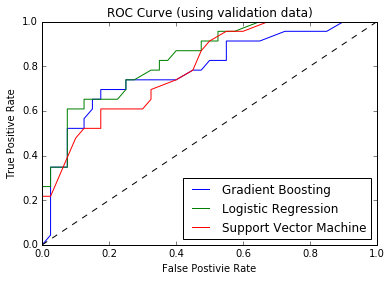

In [20]:
# Plot ROC curve
plt.figure()
for key, grp in roc_df.groupby(["Model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Postivie Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()